# Which hard drives are the most reliable? 

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# py files
import acquire
import prepare
import explore

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Project Plan

Goal
- Determine which hard drives are the most reliable by classifing and predicting hard drive failure rates. 

Hypotheses
- h1 
- h2


## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016, 2017, 2108, and 2019 was utilized. The files were downloaded to a local computer and the files were unzipped. The files were renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns the dataframe in pandas. 
- Using Spark, a dataframe was created from each directory of csv files. The dataframes are concated together with their common columns. This gave a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identified 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats were extracted and the dataframe was aggregated by serial number. This reduced the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to pandas 
- The pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

The csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead creating the dataframe.  

In [3]:
df = acquire.acquire_agg_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [5]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [6]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [7]:
df.isnull().sum()

serial_number             1
model                     0
capacity_bytes            0
max(failure)              0
max(smart_9_raw)       7098
max(smart_5_raw)       7222
max(smart_187_raw)    64884
max(smart_188_raw)    64894
max(smart_197_raw)     7232
max(smart_198_raw)     7232
dtype: int64

## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to gigabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manfacturer.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [8]:
df = prepare.prepare(df)

The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

In [9]:
df = prepare.unique(df)

In [10]:
df.head()

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,NaN,NaN,0.0,0.0


In [11]:
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_gigabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [12]:
df.shape

(162025, 11)

## Explore

Questions to answer:
- What does our data look like?
    - How many different models?
    - How many different manufacturers?
    - What are the different capacity sizes? 
    - How many hard drives are there for each manufacturer? Model?
- Does the data we obtained make sense? 
- Are there any observations that need to be dropped (why, how many)?
- Determine how to treat null values.
- Determine early failure cutoff by analyzing data.
- Does the average age of drive vary by model number?
- Which SMART attributes correlate most strongly with failure? 
- Which features or combination of features correlate with early failure?
- Do failure rates vary by model?

In [13]:
df.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,162025.000000,162025.000000,161965.000000,161841.000000,104186.000000,1.041760e+05,161831.000000,161831.000000
mean,7126.256126,0.036550,2.720621,69.854987,5.996362,3.264917e+08,6.266278,5.913626
std,3797.898582,0.187655,1.525815,1393.279910,541.372456,3.014704e+10,452.162209,447.564076
min,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4000.800000,0.000000,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,6001.200000,0.000000,2.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12000.100000,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14000.500000,1.000000,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [14]:
df.shape

(162025, 11)

In [15]:
df[df.failure==0].shape

(156103, 11)

In [16]:
df[df.failure==1].shape

(5922, 11)

In [17]:
5922/162025

0.036549915136553

In [18]:
df = prepare.treat_nulls(df)

In [19]:
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_gigabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [20]:
df.drive_age_in_years.describe()

count    161830.000000
mean          2.722672
std           1.524771
min           0.000000
25%           1.600000
50%           2.600000
75%           4.000000
max          10.300000
Name: drive_age_in_years, dtype: float64

In [21]:
df.head()

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,0.0,0.0,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,0.0,0.0,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,0.0,0.0,0.0,0.0


In [22]:
df = explore.early_failure(df)
df = explore.get_quartile(df)
df = prepare.old_or_fail(df)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121902 entries, 0 to 168960
Data columns (total 13 columns):
serial_number                    121902 non-null object
manufacturer                     121902 non-null object
model                            121902 non-null object
capacity_gigabytes               121902 non-null float64
failure                          121902 non-null int64
drive_age_in_years               121902 non-null float64
reallocated_sectors_count        121902 non-null float64
reported_uncorrectable_errors    121902 non-null float64
command_timeout                  121902 non-null float64
current_pending_sector_count     121902 non-null float64
uncorrectable_sector_count       121902 non-null float64
early_failure                    121902 non-null int64
quartile                         121902 non-null object
dtypes: float64(7), int64(2), object(4)
memory usage: 13.0+ MB


In [24]:
sns.set(rc={'figure.figsize':(15,15)})

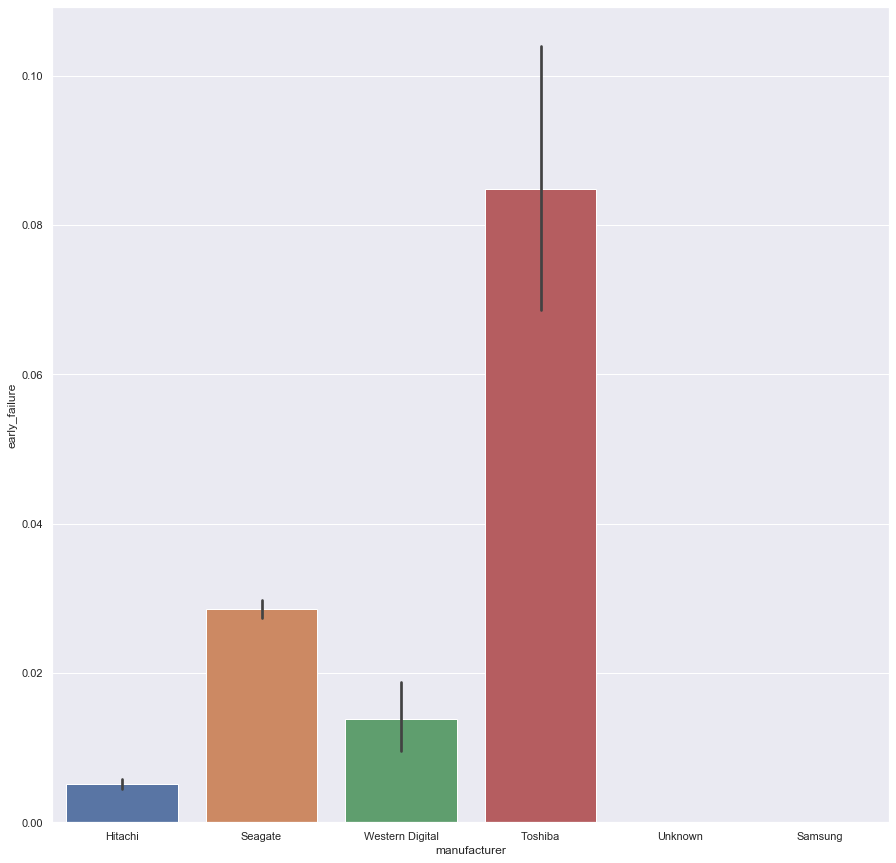

In [25]:
sns.barplot(df.manufacturer,df.early_failure)

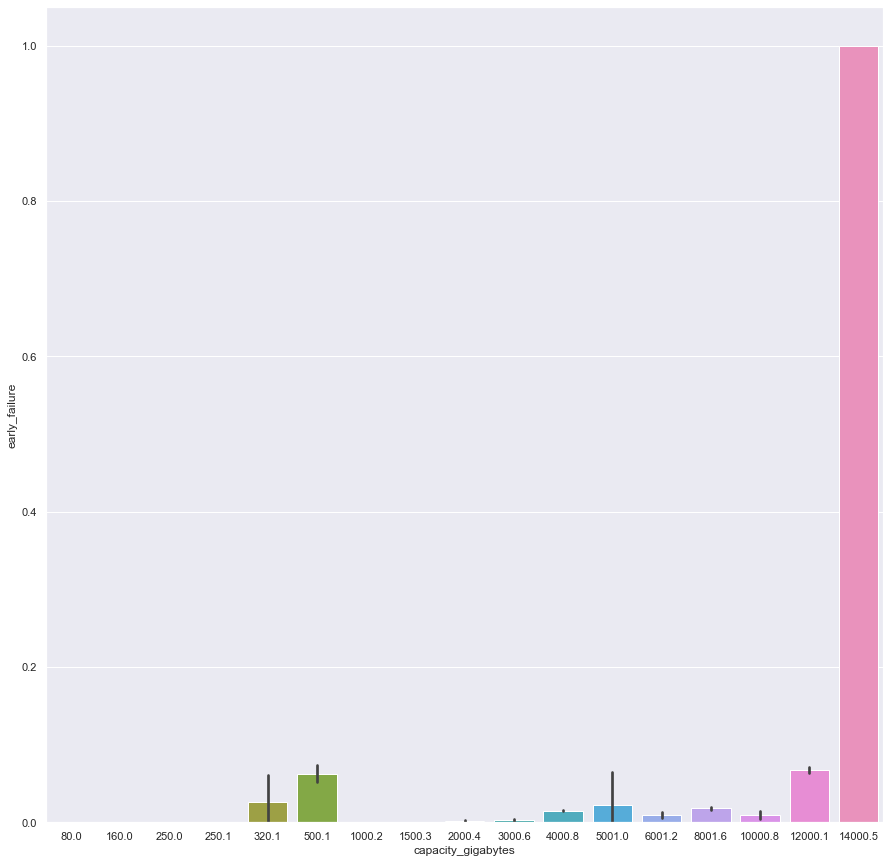

In [26]:
sns.barplot(df.capacity_gigabytes,df.early_failure)

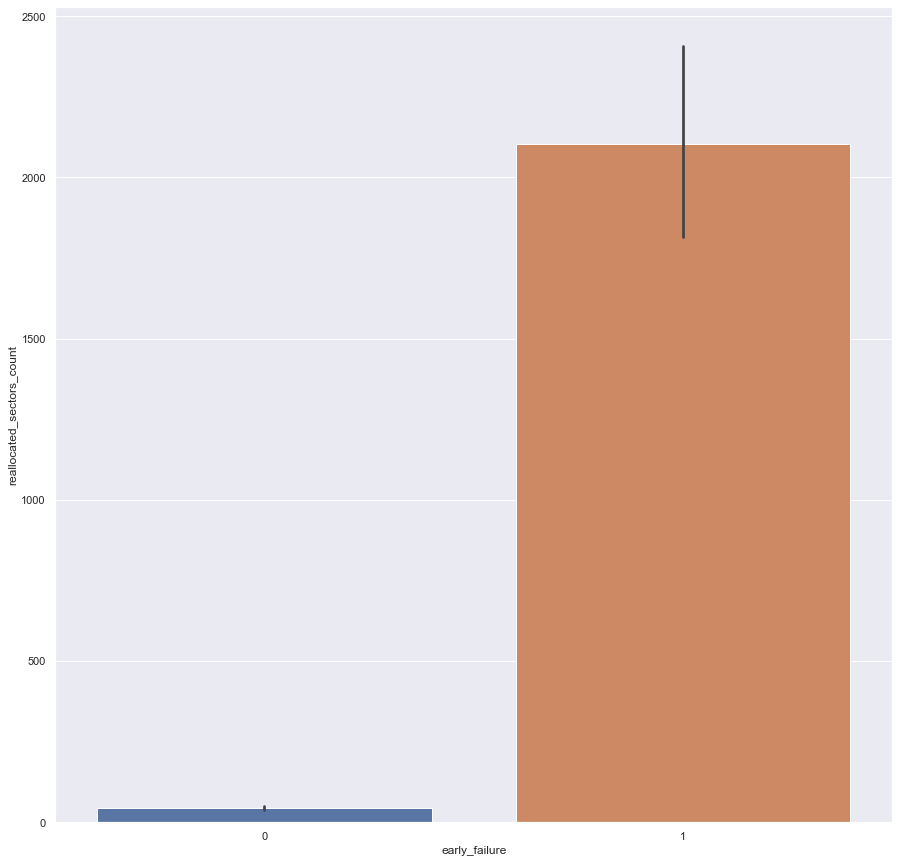

In [27]:
sns.barplot(df.early_failure,df.reallocated_sectors_count)

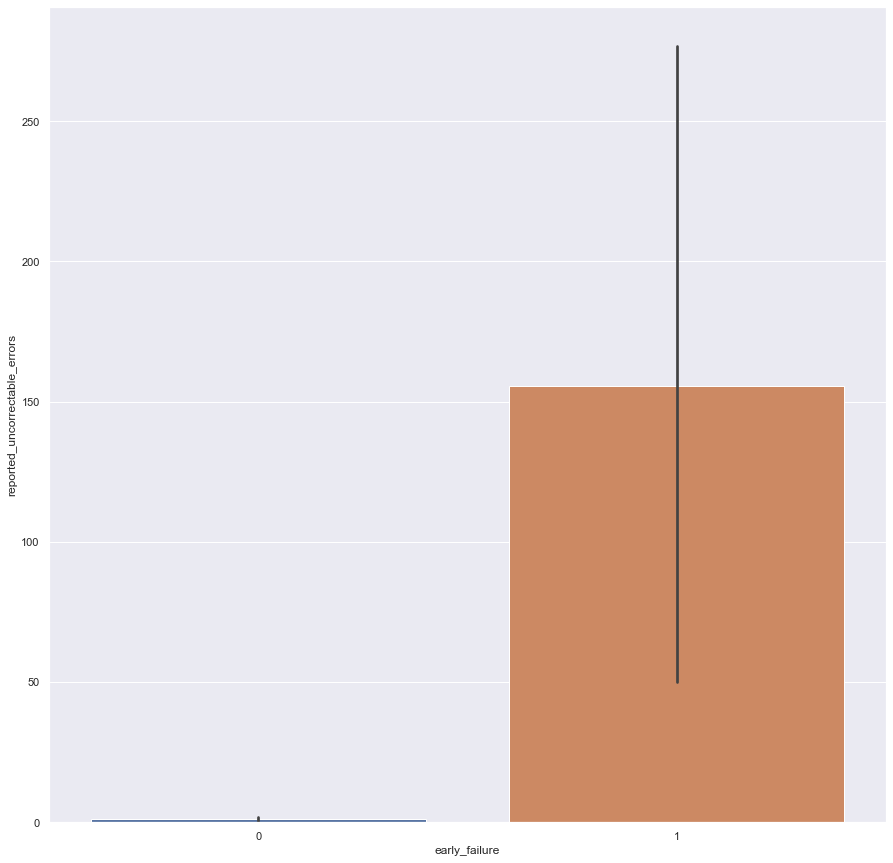

In [28]:
sns.barplot(df.early_failure,df.reported_uncorrectable_errors)

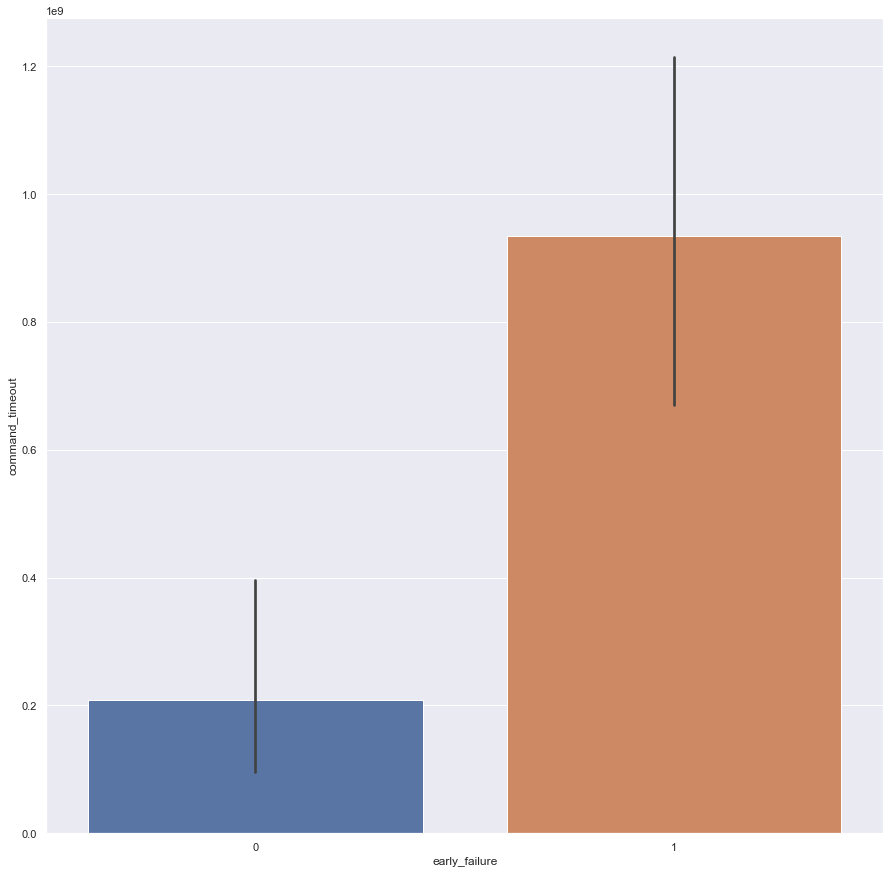

In [29]:
sns.barplot(df.early_failure,df.command_timeout)

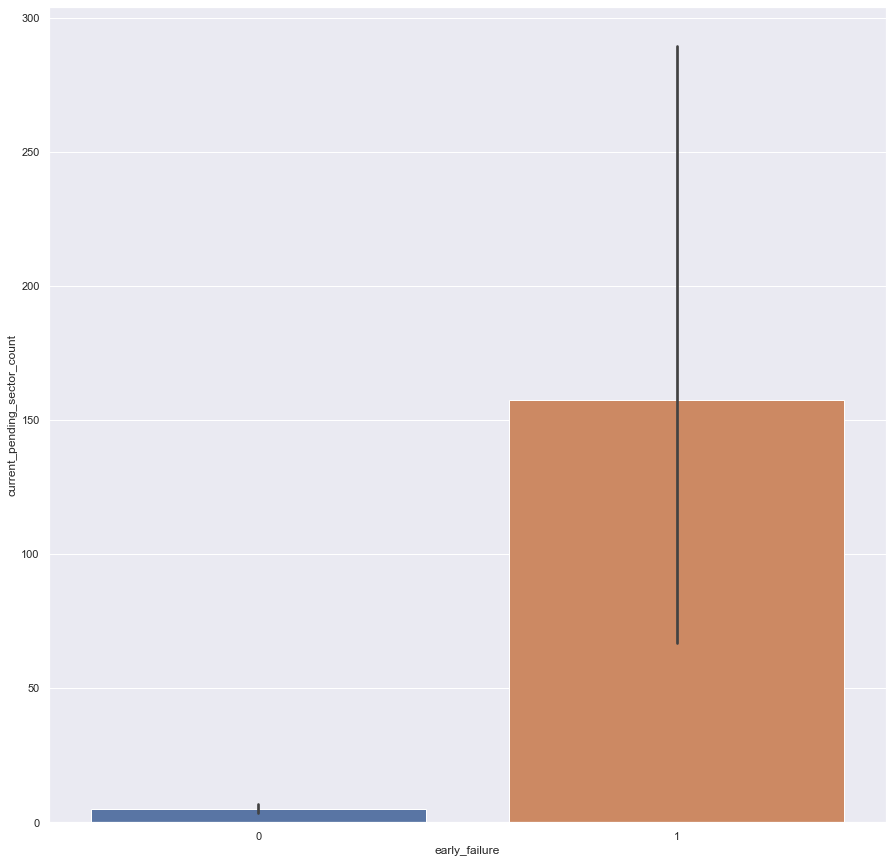

In [30]:
sns.barplot(df.early_failure,df.current_pending_sector_count)

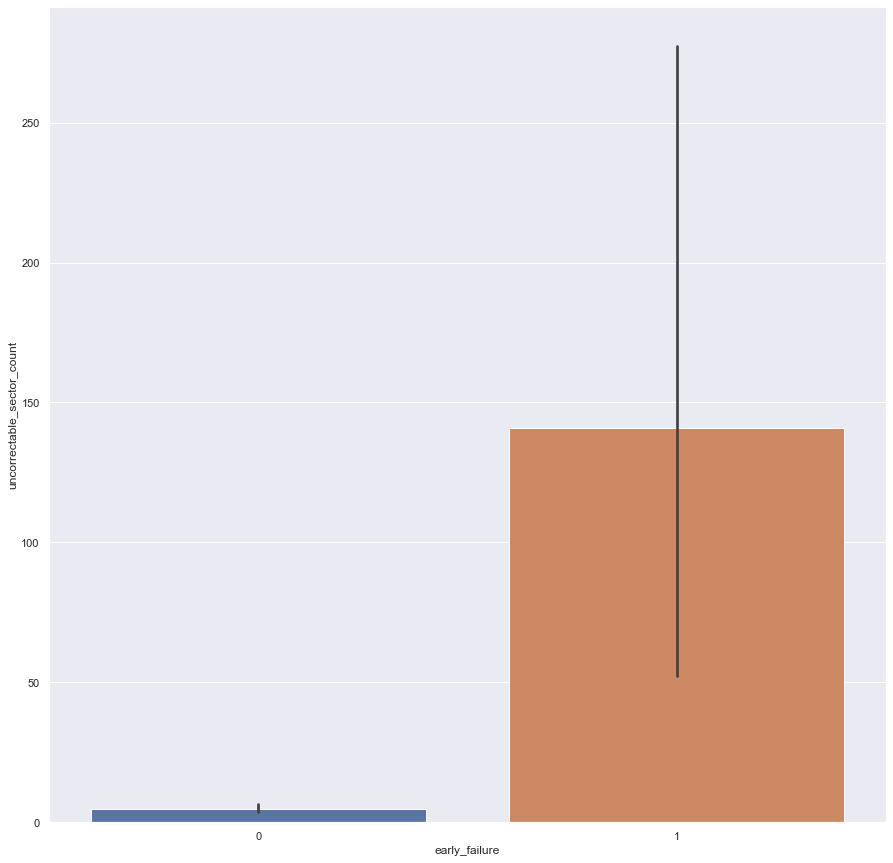

In [31]:
sns.barplot(df.early_failure,df.uncorrectable_sector_count)

In [32]:
df.drive_age_in_years.max()

10.3

In [33]:
df.drive_age_in_years.min()

0.0

In [34]:
df.drive_age_in_years.mean()

3.3518703548755377

In [35]:
df.drive_age_in_years.median()

3.4

In [36]:
df[df.early_failure==0].drive_age_in_years.max()

10.3

In [37]:
df[df.early_failure==0].drive_age_in_years.min()

1.7

In [38]:
df.drive_age_in_years.max()

10.3

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))